In [1]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray
import pdal
from dask.distributed import Client

from dask.distributed import Client

from forest_structure_tools.metrics import forest_structure_metrics

In [ ]:
data_dir = Path('../data/outputs')
sites_dir = data_dir / "sites"
sites_lidar_dir = sites_dir / "lidar"
sites_metrics_dir = sites_dir / "metrics"
output_dir = sites_metrics_dir / "x1-y1-z1" / "net_cdf"

output_dir.mkdir(parents=True, exist_ok=True)

def read_site(site_id):
    input_path = sites_lidar_dir / f"{site_id}.copc.laz"
    pl = (
        pdal.Reader(str(input_path), type="readers.copc")
        | pdal.Filter(type="filters.range", limits="Classification[0:5]")
    )
    count = pl.execute()
    print(f"Read in {count:,d} points")
    return pl.arrays[0]

def calculate_metrics(
    site_id: str,
    xy_bin_size = 1,
    z_bin_size = 1,
):
    points = read_site(site_id)
    metrics = forest_structure_metrics(
        points,
        xy_bin_size=xy_bin_size,
        z_bin_size=z_bin_size,
    )
    metrics.attrs["site_id"] = site_id

    # Add coordinate reference system and spatial dimensions
    metrics.rio.write_crs(7855, inplace=True)
    metrics.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    metrics.rio.write_coordinate_system(inplace=True)

    # Transpose for plotting and exporting to GeoTiffs
    metrics = metrics.transpose('y', 'x', 'z')

    return metrics

def calculate_and_save_metrics(site_id: str):
    metrics = calculate_metrics(site_id)
    metrics.to_netcdf(output_dir / f"{site_id}.nc")


In [6]:
metrics = calculate_metrics("EPO_Y_10")
metrics

Read in 2,205,556 points


<xarray.Dataset> Size: 155MB
Dimensions:               (x: 173, y: 280, z: 37)
Coordinates:
  * x                     (x) float64 1kB 4.622e+05 4.622e+05 ... 4.623e+05
  * y                     (y) float64 2kB 5.26e+06 5.26e+06 ... 5.26e+06
  * z                     (z) float64 296B 0.0 1.0 2.0 3.0 ... 34.0 35.0 36.0
    spatial_ref           int64 8B 0
Data variables: (12/40)
    point_density         (y, x) float64 388kB nan nan nan nan ... nan nan nan
    pulse                 (y, x) float64 388kB nan nan nan nan ... nan nan nan
    chm                   (y, x) float64 388kB nan nan nan nan ... nan nan nan
    mean_height           (y, x) float64 388kB nan nan nan nan ... nan nan nan
    median_height         (y, x) float64 388kB nan nan nan nan ... nan nan nan
    q10_veg_height        (y, x) float64 388kB nan nan nan nan ... nan nan nan
    ...                    ...
    vci                   (y, x) float64 388kB nan nan nan nan ... nan nan nan
    vci_w                 (y, x) float64 388kB nan nan nan nan ... nan nan nan
    shann_capture         (y, x) float64 388kB nan nan nan nan ... nan nan nan
    shann_capture_w       (y, x) float64 388kB nan nan nan nan ... nan nan nan
    norm_shann_capture    (y, x) float64 388kB nan nan nan nan ... nan nan nan
    norm_shann_capture_w  (y, x) float64 388kB nan nan nan nan ... nan nan nan
Attributes:
    xy_bin_size:  1
    z_bin_size:   1
    site_id:      EPO_Y_10

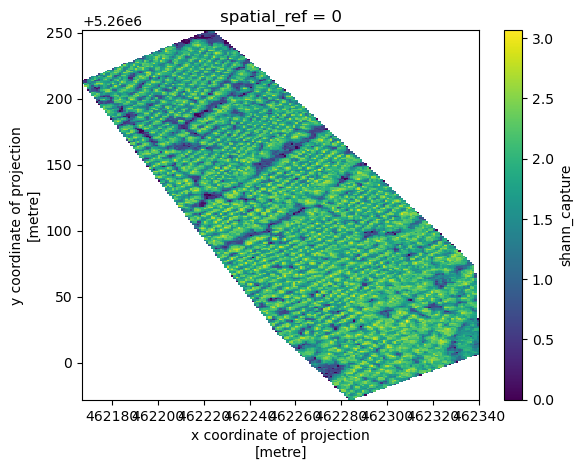

In [7]:
metrics['shann_capture'].plot()

In [5]:
%%time

calculate_and_save_metrics("EPO_Y_10")

Read in 2,205,556 points
CPU times: user 52.1 s, sys: 491 ms, total: 52.6 s
Wall time: 52.3 s


In [9]:
sites_gdf = gpd.read_file(sites_dir / "sites.geojson")
site_ids = sites_gdf['id'].to_list()[:10]

In [ ]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55917,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:55924,Total threads: 2
Dashboard: http://127.0.0.1:55926/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:55920,


In [10]:
%%time

futures = client.map(calculate_and_save_metrics, site_ids, key=site_ids, retries=4)
results = client.gather(futures)

Read in 2,075,108 points
Read in 2,283,721 points
Read in 2,365,219 points
Read in 3,572,055 points
Read in 2,472,162 points
Read in 2,825,310 points
Read in 1,757,776 points
Read in 1,783,411 points
Read in 1,897,784 points
Read in 3,037,385 points
CPU times: user 14.2 s, sys: 3.3 s, total: 17.5 s
Wall time: 12min 14s


In [9]:
client.close()